

> TFG (No es la version final)




1.   Importación de datos
2.   Preprocesamiento de los datos
3.   Modelo de clasificacion (transfer learning y modelo simple)
4.   Modelo de segmentacion con los resultados del modelo anterior
5.   Representacion de los resultados




# Librerias

In [1]:
import zipfile
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, ResNet50
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

# 1. Importación de los datos


In [2]:
def extract_zip(zip_path, dest_dir):
    """
    Extrae el contenido de un archivo zip a un directorio de destino.

    Args:
        zip_path (str): La ruta al archivo zip.
        dest_dir (str): El directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Define las rutas del archivo zip y el directorio de destino
zip_file_path = '/content/archive.zip'
destination_directory = '/content'

# Llama a la función para extraer el archivo
if os.path.exists(zip_file_path):
    extract_zip(zip_file_path, destination_directory)
    print(f"Archivo '{zip_file_path}' extraído a '{destination_directory}'")
else:
    print(f"El archivo '{zip_file_path}' no fue encontrado.")

Archivo '/content/archive.zip' extraído a '/content'


In [3]:
def importar(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                image_list.append(img)
            except Exception as e:
                print(f"No se pudo abrir la imagen {filename}: {e}")
    return image_list

In [4]:
imagenes_ct_sanas = importar('/content/Dataset/Brain Tumor CT scan Images/Healthy')
imagenes_ct_tumor = importar('/content/Dataset/Brain Tumor CT scan Images/Tumor')
imagenes_mri_sanas = importar('/content/Dataset/Brain Tumor MRI images/Healthy')
imagenes_mri_tumor = importar('/content/Dataset/Brain Tumor MRI images/Tumor')

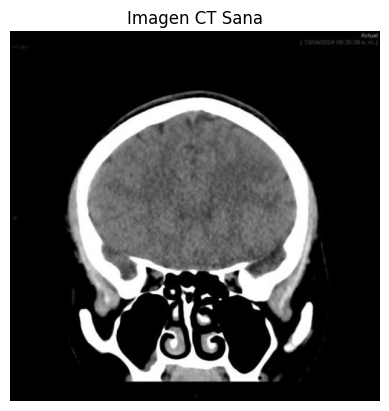

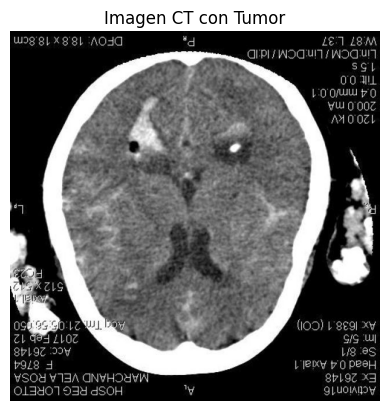

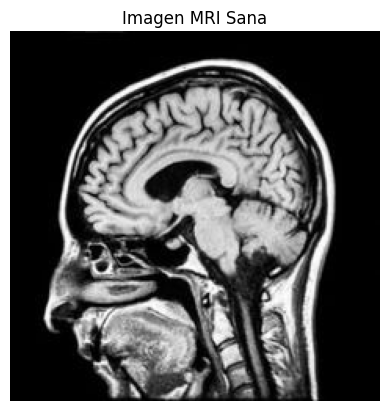

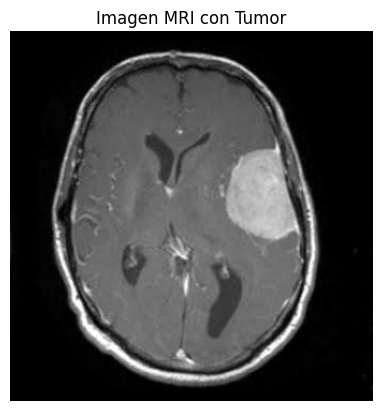

In [5]:
def display_image(image_list, title):
    if image_list:
        random_index = np.random.randint(0, len(image_list))
        plt.imshow(image_list[random_index], cmap='grey')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"La lista '{title}' está vacía.")

display_image(imagenes_ct_sanas, "Imagen CT Sana")
display_image(imagenes_ct_tumor, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas, "Imagen MRI Sana")
display_image(imagenes_mri_tumor, "Imagen MRI con Tumor")

# 2. Preprocesamiento de los datos

In [6]:
def preprocess_images(image_list, target_size=(256, 256)):
    processed_images = []
    for img in image_list:
        # Convierto a array NumPy y asegurar que sea RGB
        img_array = np.array(img.convert('RGB')) if img.mode != 'RGB' else np.array(img)
        # Redimensiono todas las imágenes al mismo tamaño objetivo
        resized_img = cv2.resize(img_array, target_size)
        # Normalizo (escalar los valores de píxel a un rango de 0 a 1)
        normalized_img = resized_img.astype('float32') / 255.0
        processed_images.append(normalized_img)
    return processed_images

imagenes_ct_sanas_processed = preprocess_images(imagenes_ct_sanas)
imagenes_ct_tumor_processed = preprocess_images(imagenes_ct_tumor)
imagenes_mri_sanas_processed = preprocess_images(imagenes_mri_sanas)
imagenes_mri_tumor_processed = preprocess_images(imagenes_mri_tumor)

print(f"Se preprocesaron {len(imagenes_ct_sanas_processed)} imágenes CT sanas.")
print(f"Se preprocesaron {len(imagenes_ct_tumor_processed)} imágenes CT con tumor.")
print(f"Se preprocesaron {len(imagenes_mri_sanas_processed)} imágenes MRI sanas.")
print(f"Se preprocesaron {len(imagenes_mri_tumor_processed)} imágenes MRI con tumor.")

Se preprocesaron 2300 imágenes CT sanas.
Se preprocesaron 2318 imágenes CT con tumor.
Se preprocesaron 2000 imágenes MRI sanas.
Se preprocesaron 3000 imágenes MRI con tumor.


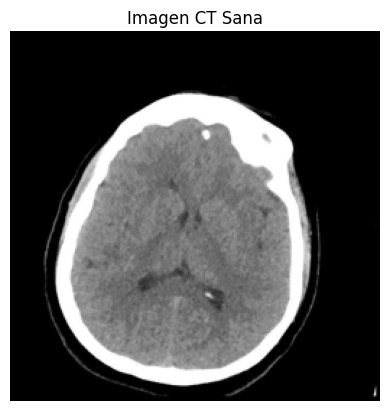

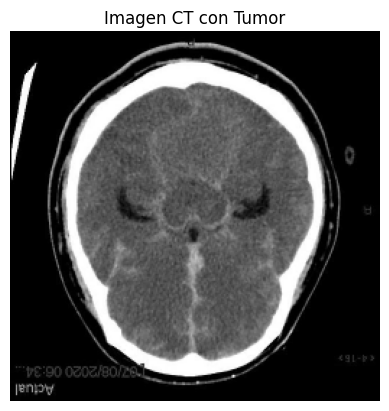

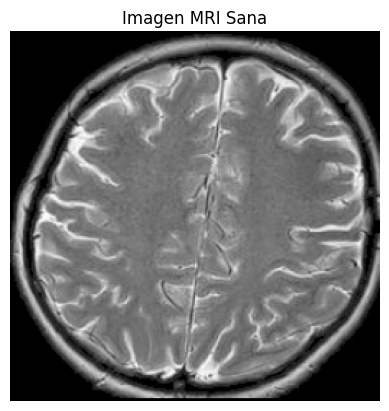

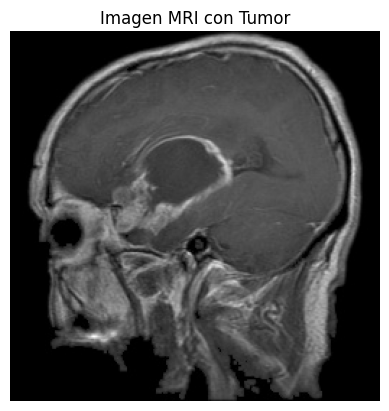

In [7]:
display_image(imagenes_ct_sanas_processed, "Imagen CT Sana")
display_image(imagenes_ct_tumor_processed, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas_processed, "Imagen MRI Sana")
display_image(imagenes_mri_tumor_processed, "Imagen MRI con Tumor")

# 3. Modelo de clasificación conjunto ct

Uso modelos preentrenados para clasificación, los modelos que voy a usar son VGG16 y RESNET50.

## VGG16

### Modelo completo

In [ ]:
imagenes_ct = imagenes_ct_sanas_processed + imagenes_ct_tumor_processed
# 0 para sanas, 1 para tumor
labels_ct = [0] * len(imagenes_ct_sanas_processed) + [1] * len(imagenes_ct_tumor_processed)
imagenes_ct = np.array(imagenes_ct)
labels_ct = np.array(labels_ct)
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(
    imagenes_ct, labels_ct,
    test_size=0.2, random_state=42, stratify=labels_ct)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_ct)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_ct)}")

Tamaño del conjunto de entrenamiento: 3694
Tamaño del conjunto de prueba: 924


In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,913 (56.16 MB)

 Trainable params: 14,722,913 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 470ms/step - accuracy: 0.5088 - loss: 1.1899 - val_accuracy: 0.4993 - val_loss: 0.6753
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.5574 - loss: 0.6752 - val_accuracy: 0.8687 - val_loss: 0.3229
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8891 - loss: 0.3071 - val_accuracy: 0.9093 - val_loss: 0.3176
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9217 - loss: 0.2224 - val_accuracy: 0.9432 - val_loss: 0.1961
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9371 - loss: 0.1753 - val_accuracy: 0.9405 - val_loss: 0.2146
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9388 - loss: 0.1794 - val_accuracy: 0.9364 - val_loss: 0.1882
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9390 - loss: 0.1772 - val_accuracy: 0.9418 - val_loss: 0.2086
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9390 - loss: 0.1632 - val_accuracy: 0

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9661 - loss: 0.1361
Pérdida en el conjunto de prueba: 0.1598
Precisión en el conjunto de prueba: 0.9600


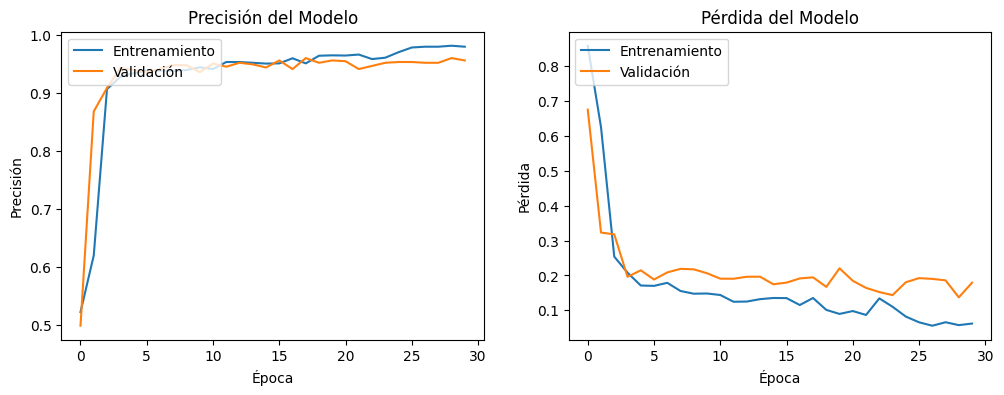

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


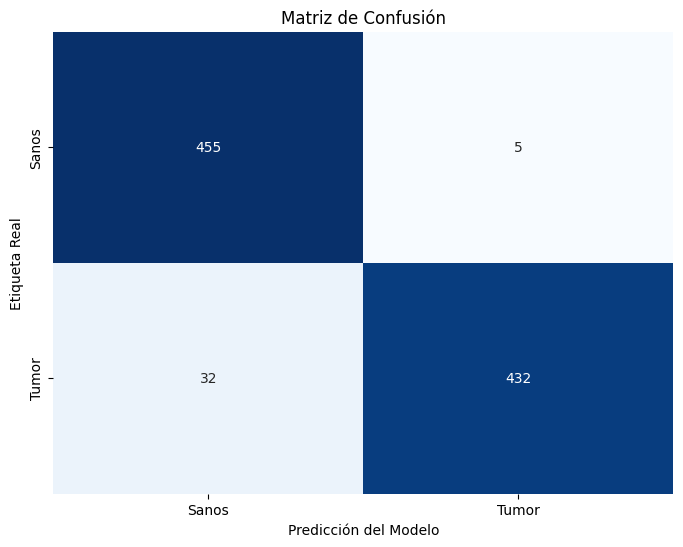

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con capas congeladas

In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,784,513 (56.40 MB)

 Trainable params: 69,825 (272.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.7684 - loss: 0.5258 - val_accuracy: 0.8972 - val_loss: 0.3258
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8978 - loss: 0.2673 - val_accuracy: 0.8985 - val_loss: 0.2567
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9131 - loss: 0.2220 - val_accuracy: 0.9337 - val_loss: 0.2265
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9403 - loss: 0.1826 - val_accuracy: 0.8985 - val_loss: 0.2892
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9296 - loss: 0.1968 - val_accuracy: 0.9107 - val_loss: 0.2245
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9493 - loss: 0.1540 - val_accuracy: 0.9283 - val_loss: 0.2035
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9410 - loss: 0.1677 - val_accuracy: 0.9378 - val_loss: 0.2227
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9516 - loss: 0.1488 - val_accuracy: 0.9445 -

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9706 - loss: 0.1089
Pérdida en el conjunto de prueba: 0.1321
Precisión en el conjunto de prueba: 0.9632


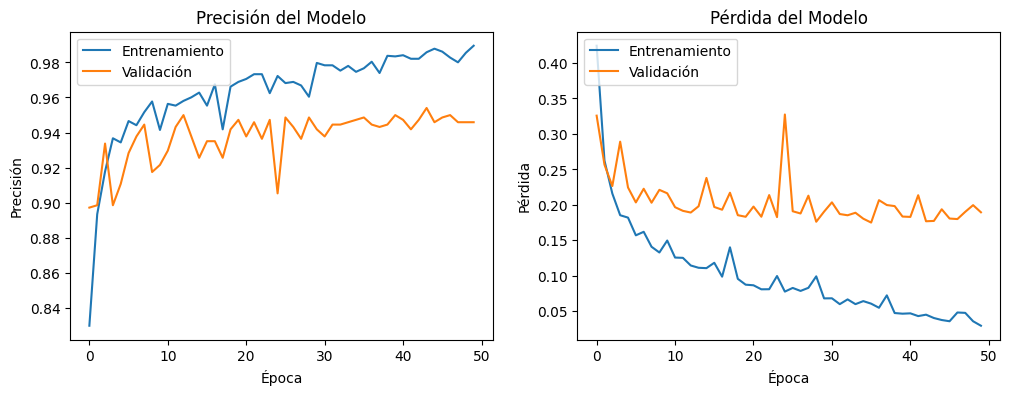

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


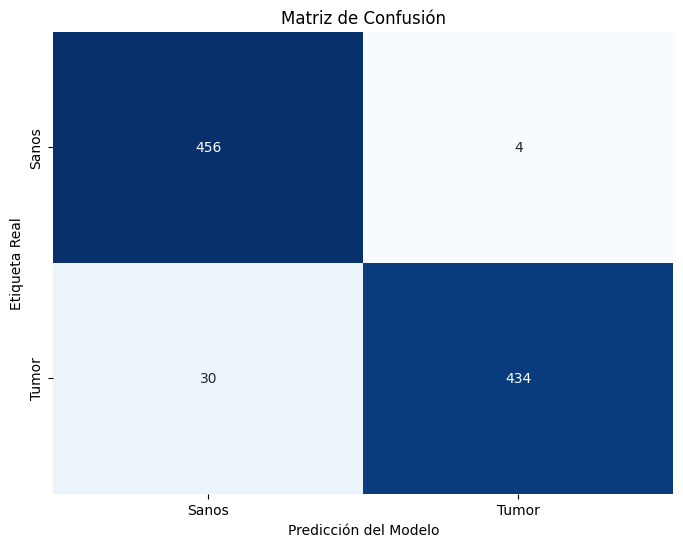

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = True

capas_a_congelar = 17


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 2,528,193 (9.64 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=35, batch_size=64, validation_split=0.2)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.7048 - loss: 0.4947 - val_accuracy: 0.9405 - val_loss: 0.2066
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9454 - loss: 0.1603 - val_accuracy: 0.9378 - val_loss: 0.1865
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9545 - loss: 0.1208 - val_accuracy: 0.8823 - val_loss: 0.3018
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9387 - loss: 0.1656 - val_accuracy: 0.9486 - val_loss: 0.1575
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9745 - loss: 0.0680 - val_accuracy: 0.9486 - val_loss: 0.1621
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9759 - loss: 0.0743 - val_accuracy: 0.9337 - val_loss: 0.1847
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9782 - loss: 0.0613 - val_accuracy: 0.9608 - val_loss: 0.1377
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9866 - loss: 0.0421 - val_accuracy: 0.9608 -

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9784 - loss: 0.1582
Pérdida en el conjunto de prueba: 0.1745
Precisión en el conjunto de prueba: 0.9740


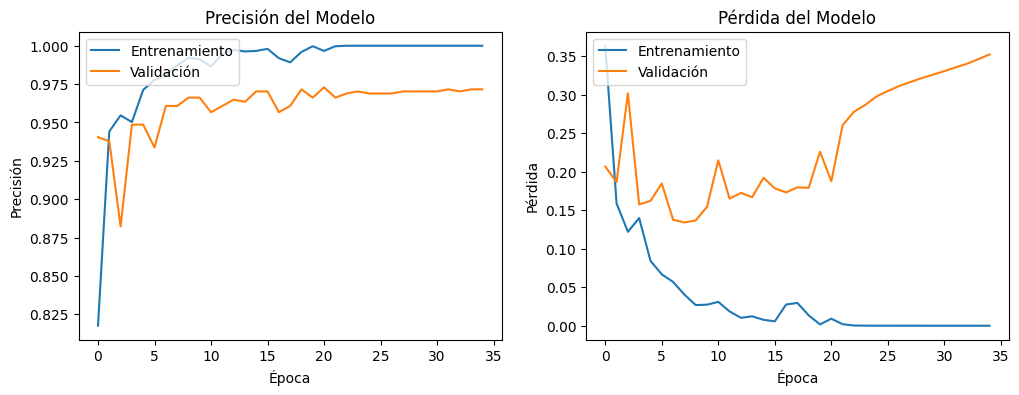

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


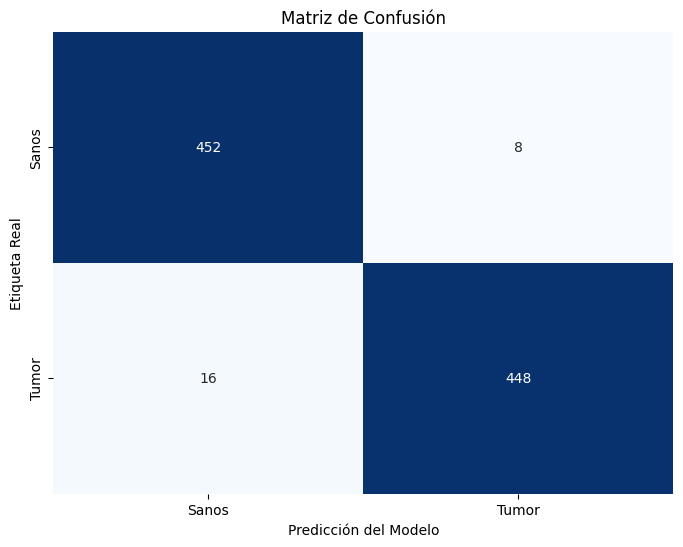

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = True

capas_a_congelar = 18


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 168,385 (657.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=40, batch_size=64, validation_split=0.2)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.7748 - loss: 0.5064 - val_accuracy: 0.8809 - val_loss: 0.3202
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8872 - loss: 0.2619 - val_accuracy: 0.9269 - val_loss: 0.2342
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9305 - loss: 0.1909 - val_accuracy: 0.8985 - val_loss: 0.2978
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9238 - loss: 0.1970 - val_accuracy: 0.8958 - val_loss: 0.2555
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9392 - loss: 0.1638 - val_accuracy: 0.9310 - val_loss: 0.2337
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9488 - loss: 0.1463 - val_accuracy: 0.9215 - val_loss: 0.2372
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9532 - loss: 0.1365 - val_accuracy: 0.9175 - val_loss: 0.2113
Epoch 8/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9553 - loss: 0.1347 - val_accuracy: 0.9405 -

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9753 - loss: 0.1067
Pérdida en el conjunto de prueba: 0.1223
Precisión en el conjunto de prueba: 0.9708


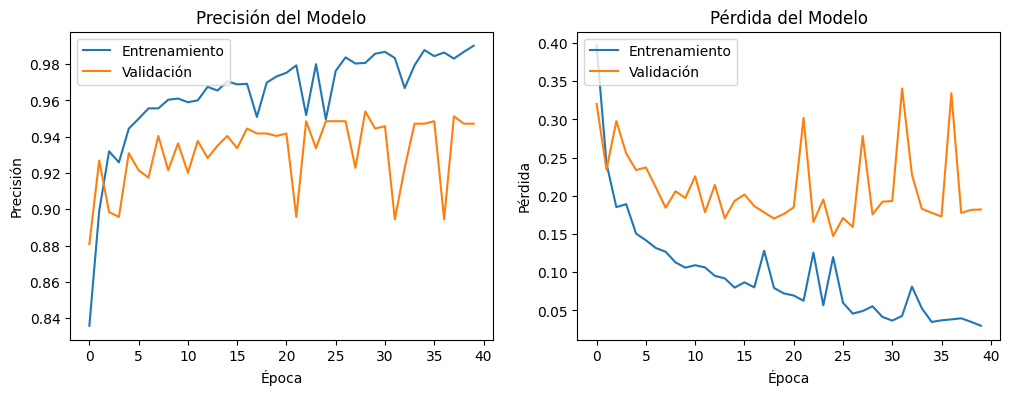

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


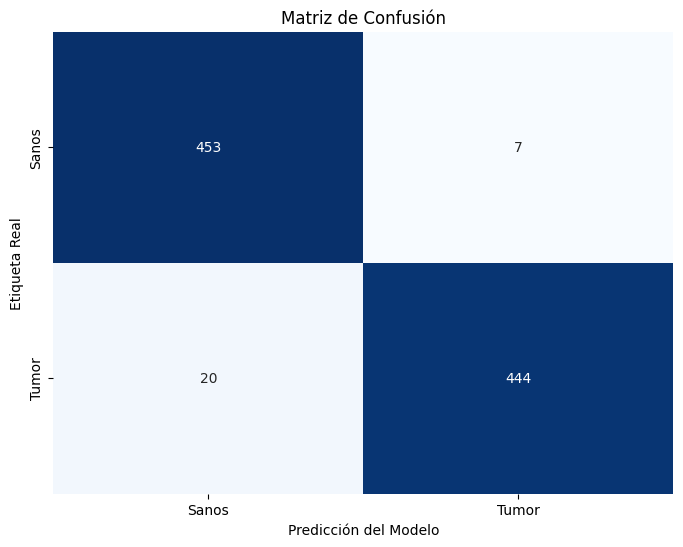

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = True

capas_a_congelar = 16


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 4,888,001 (18.65 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.7187 - loss: 0.5755 - val_accuracy: 0.8823 - val_loss: 0.3208
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9320 - loss: 0.1851 - val_accuracy: 0.9472 - val_loss: 0.1807
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9577 - loss: 0.1126 - val_accuracy: 0.9513 - val_loss: 0.1579
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9693 - loss: 0.0973 - val_accuracy: 0.9608 - val_loss: 0.1432
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9748 - loss: 0.0869 - val_accuracy: 0.9567 - val_loss: 0.1377
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9815 - loss: 0.0570 - val_accuracy: 0.9648 - val_loss: 0.1382
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9871 - loss: 0.0418 - val_accuracy: 0.9608 - val_loss: 0.1267
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9882 - loss: 0.0454 - val_accuracy: 0.9581 -

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9789 - loss: 0.1026
Pérdida en el conjunto de prueba: 0.1153
Precisión en el conjunto de prueba: 0.9773


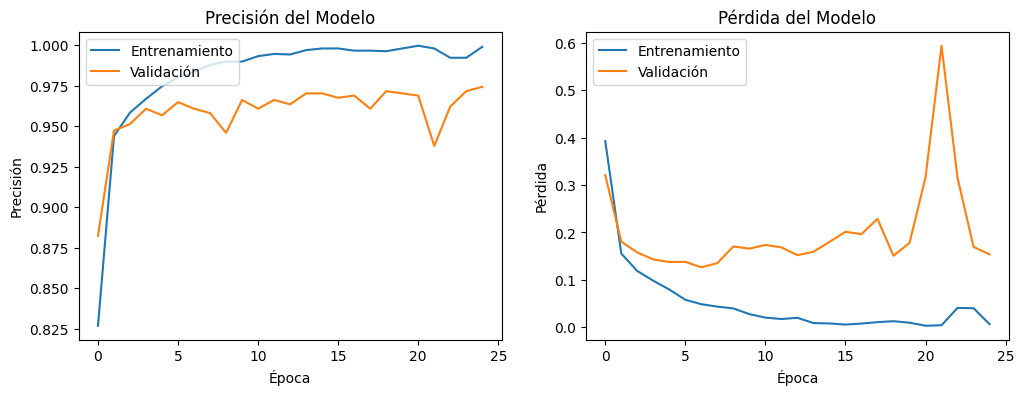

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


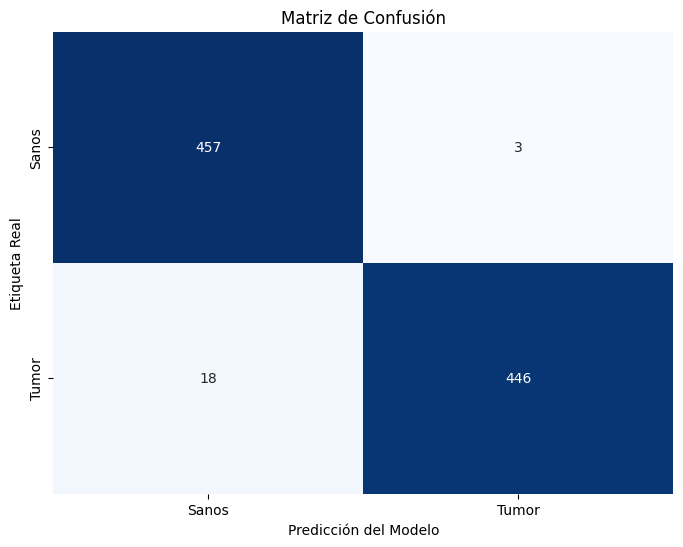

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## RESNET 50

### Modelo completo

In [ ]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 23,807,233 (90.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 91s 815ms/step - accuracy: 0.8919 - loss: 0.2462 - val_accuracy: 0.4993 - val_loss: 316.7810
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9668 - loss: 0.0865 - val_accuracy: 0.5007 - val_loss: 4.8359
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9778 - loss: 0.0568 - val_accuracy: 0.5007 - val_loss: 0.7107
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9837 - loss: 0.0495 - val_accuracy: 0.5007 - val_loss: 0.7807
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9857 - loss: 0.0430 - val_accuracy: 0.5007 - val_loss: 2.5345
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9491 - loss: 0.1525 - val_accuracy: 0.5020 - val_loss: 0.7263
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9842 - loss: 0.0520 - val_accuracy: 0.5007 - val_loss: 0.7186
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9916 - loss: 0.0358 - val_accuracy:

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.5036 - loss: 0.8885
Pérdida en el conjunto de prueba: 0.8997
Precisión en el conjunto de prueba: 0.4903


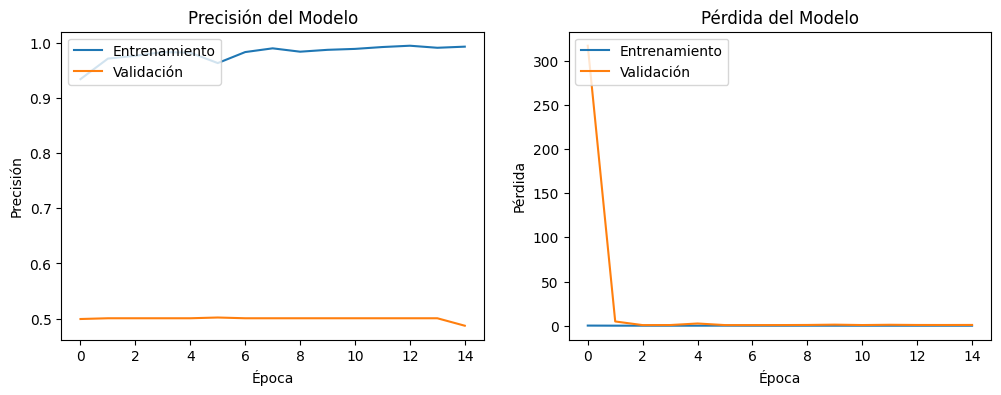

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step


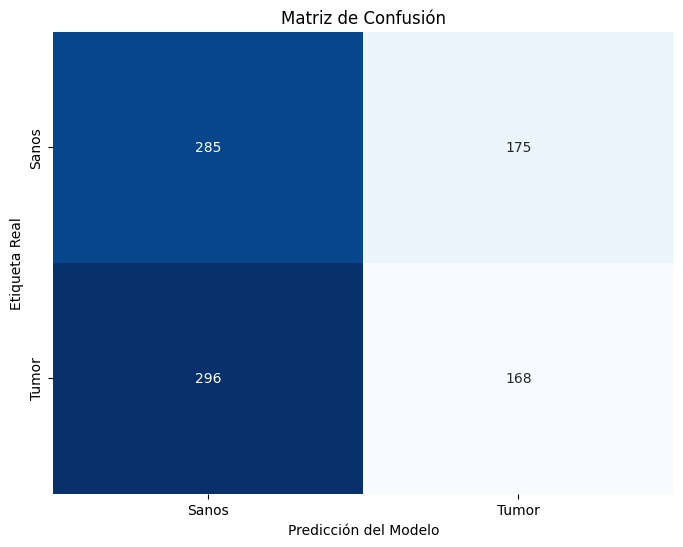

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con capas congeladas

In [ ]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=80, batch_size=64, validation_split=0.2)

Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 463ms/step - accuracy: 0.6331 - loss: 0.6350 - val_accuracy: 0.7361 - val_loss: 0.5343
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7841 - loss: 0.4840 - val_accuracy: 0.7808 - val_loss: 0.4910
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8148 - loss: 0.4158 - val_accuracy: 0.7889 - val_loss: 0.4406
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8385 - loss: 0.3916 - val_accuracy: 0.8227 - val_loss: 0.4047
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8315 - loss: 0.3760 - val_accuracy: 0.8363 - val_loss: 0.3835
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8511 - loss: 0.3424 - val_accuracy: 0.7713 - val_loss: 0.4939
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8605 - loss: 0.3374 - val_accuracy: 0.7524 - val_loss: 0.6323
Epoch 8/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8155 - loss: 0.4071 - val_accuracy: 0.8363 -

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - accuracy: 0.8775 - loss: 0.3406
Pérdida en el conjunto de prueba: 0.3254
Precisión en el conjunto de prueba: 0.8864


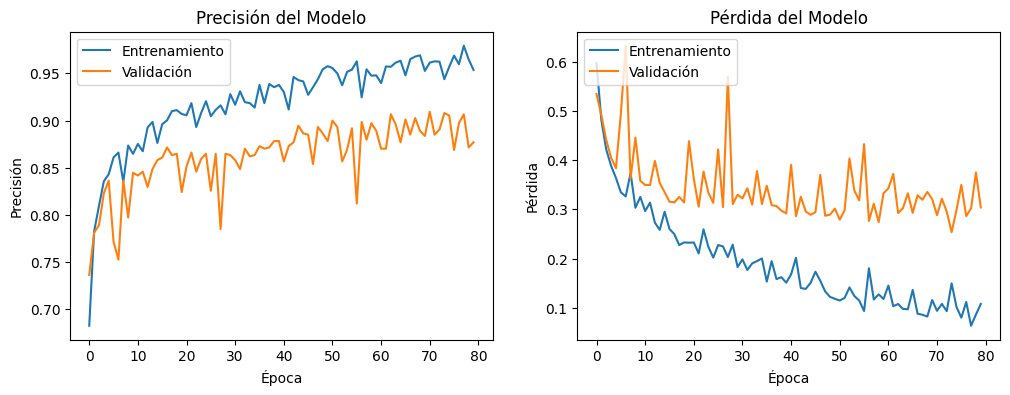

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step


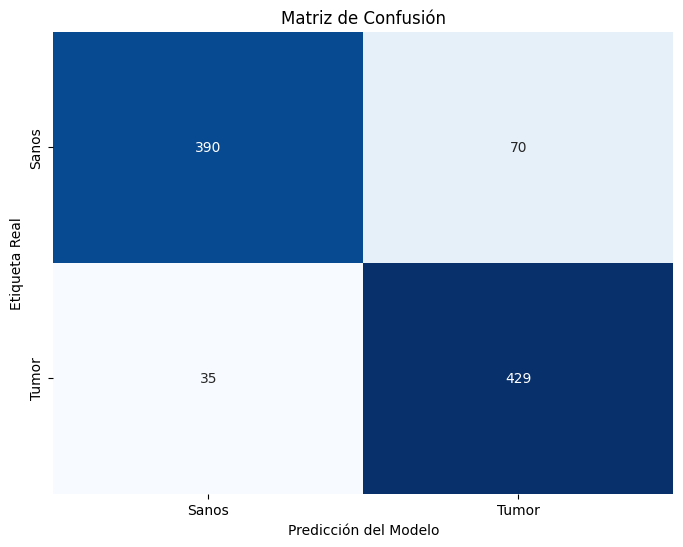

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Transfer Learning en dos pasos

In [ ]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=80, batch_size=64, validation_split=0.2)

Epoch 1/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step - accuracy: 0.5833 - loss: 0.6611 - val_accuracy: 0.7158 - val_loss: 0.5670
Epoch 2/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7743 - loss: 0.4926 - val_accuracy: 0.7835 - val_loss: 0.4805
Epoch 3/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8010 - loss: 0.4505 - val_accuracy: 0.7889 - val_loss: 0.4750
Epoch 4/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8073 - loss: 0.4282 - val_accuracy: 0.7727 - val_loss: 0.4873
Epoch 5/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8384 - loss: 0.3736 - val_accuracy: 0.8187 - val_loss: 0.4071
Epoch 6/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8390 - loss: 0.3650 - val_accuracy: 0.7876 - val_loss: 0.4319
Epoch 7/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8384 - loss: 0.3683 - val_accuracy: 0.7564 - val_loss: 0.5328
Epoch 8/80
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8182 - loss: 0.4046 - val_accuracy: 0.8146 -

In [ ]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 760ms/step - accuracy: 0.7671 - loss: 29.1143 - val_accuracy: 0.5007 - val_loss: 18.7868
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9492 - loss: 3.7471 - val_accuracy: 0.5169 - val_loss: 23.0181
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9842 - loss: 0.7456 - val_accuracy: 0.4682 - val_loss: 33.5368
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9938 - loss: 0.3143 - val_accuracy: 0.4371 - val_loss: 38.1105
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9963 - loss: 0.0598 - val_accuracy: 0.4587 - val_loss: 45.0193
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9978 - loss: 0.0428 - val_accuracy: 0.4750 - val_loss: 51.1971
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9940 - loss: 0.1316 - val_accuracy: 0.4804 - val_loss: 56.5797
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9938 - loss: 0.1111 - val_acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9695 - loss: 2.6391
Pérdida en el conjunto de prueba: 2.6310
Precisión en el conjunto de prueba: 0.9654


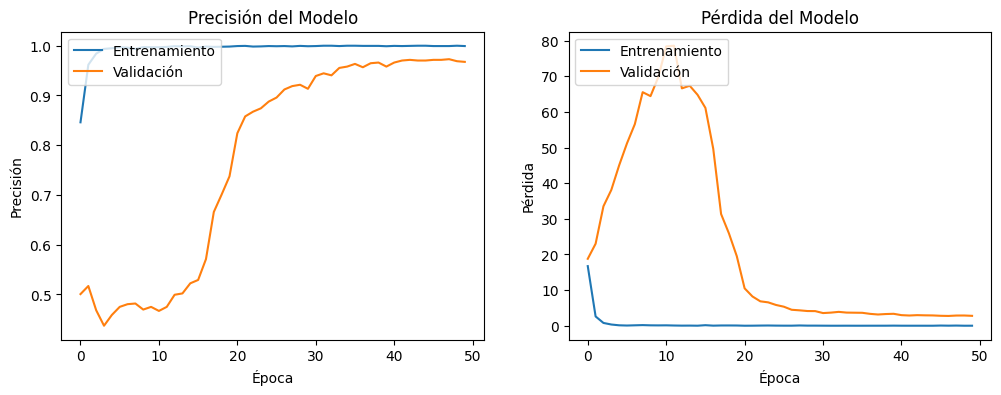

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step


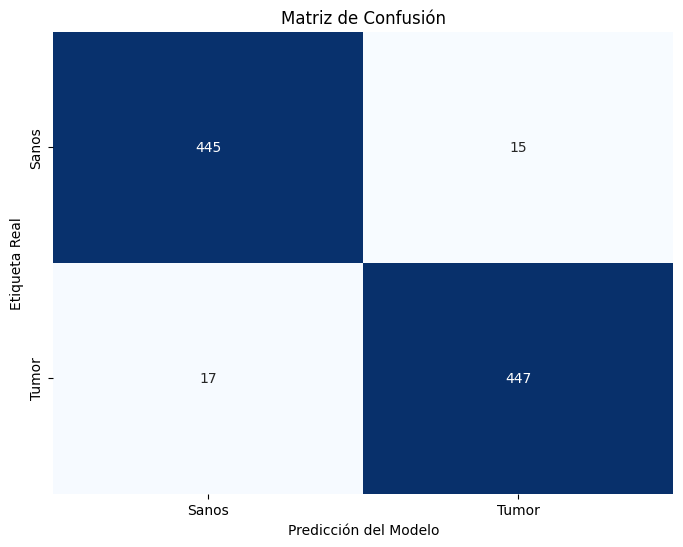

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [ ]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = True

capas_a_congelar = 143


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 15,248,641 (58.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [ ]:
history = model.fit(X_train_ct, y_train_ct, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 965ms/step - accuracy: 0.7855 - loss: 0.4463 - val_accuracy: 0.4993 - val_loss: 0.6716
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9125 - loss: 0.2072 - val_accuracy: 0.7415 - val_loss: 0.5812
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9605 - loss: 0.1015 - val_accuracy: 0.7727 - val_loss: 0.5226
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9677 - loss: 0.0833 - val_accuracy: 0.7442 - val_loss: 0.4941
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9586 - loss: 0.0920 - val_accuracy: 0.7388 - val_loss: 0.4978
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9632 - loss: 0.0878 - val_accuracy: 0.8579 - val_loss: 0.3196
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9765 - loss: 0.0596 - val_accuracy: 0.7645 - val_loss: 0.7437
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9736 - loss: 0.0684 - val_accuracy: 0.6685 -

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9547 - loss: 0.1841
Pérdida en el conjunto de prueba: 0.2137
Precisión en el conjunto de prueba: 0.9437


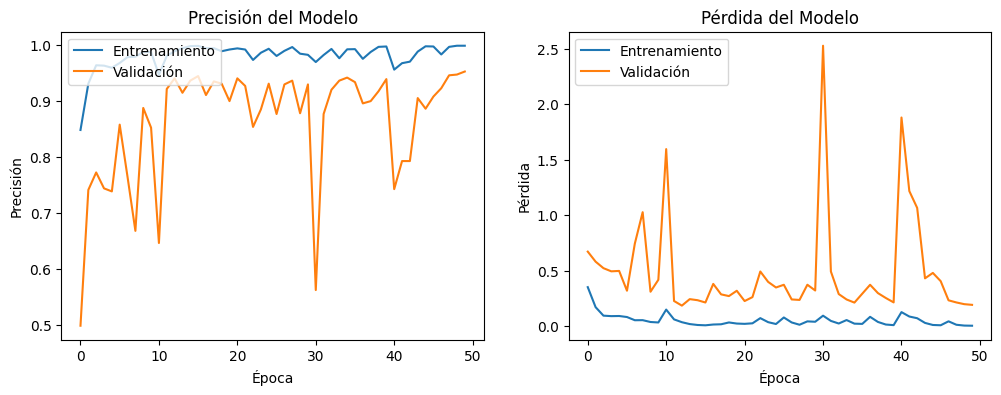

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step


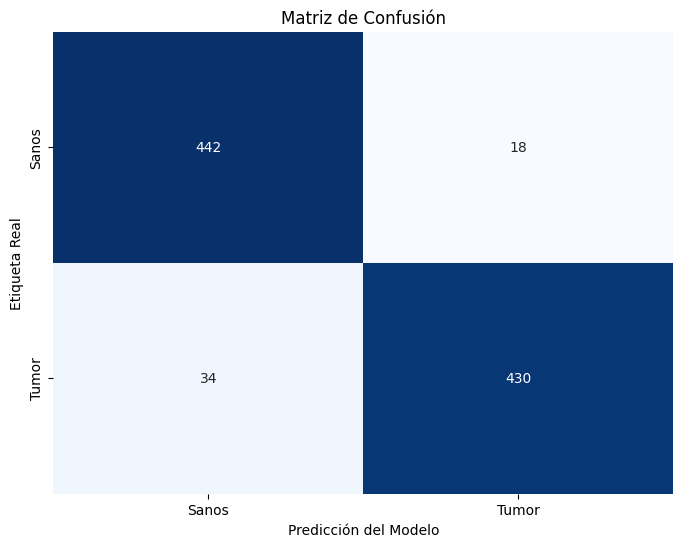

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [ ]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = True

capas_a_congelar = 80


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 22,357,249 (85.29 MB)

 Non-trainable params: 1,503,104 (5.73 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

history = model.fit(X_train_ct, y_train_ct, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 994ms/step - accuracy: 0.7893 - loss: 0.4331 - val_accuracy: 0.5007 - val_loss: 0.7745
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9446 - loss: 0.1356 - val_accuracy: 0.5007 - val_loss: 0.8745
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9797 - loss: 0.0600 - val_accuracy: 0.5007 - val_loss: 1.1842
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9444 - loss: 0.1468 - val_accuracy: 0.6982 - val_loss: 0.5569
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9653 - loss: 0.0919 - val_accuracy: 0.6996 - val_loss: 0.6663
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9865 - loss: 0.0372 - val_accuracy: 0.7889 - val_loss: 0.4693
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9713 - loss: 0.0804 - val_accuracy: 0.8809 - val_loss: 0.2872
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9865 - loss: 0.0427 - val_accuracy: 0

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9787 - loss: 0.1047
Pérdida en el conjunto de prueba: 0.1344
Precisión en el conjunto de prueba: 0.9708


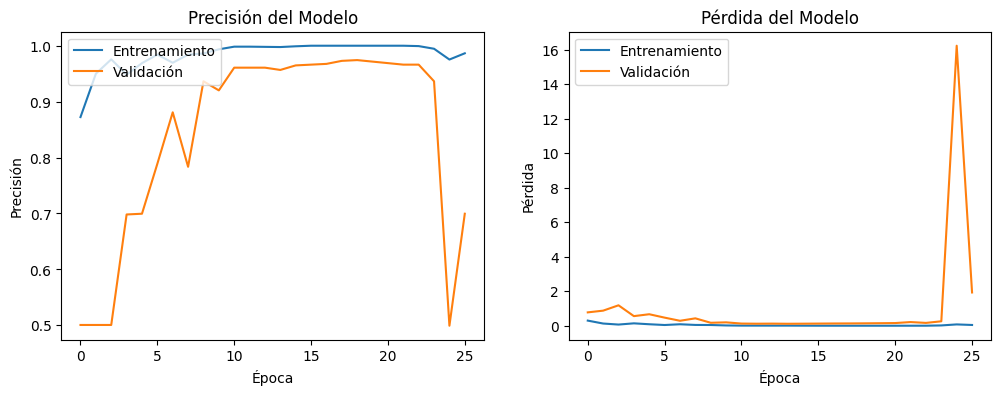

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step


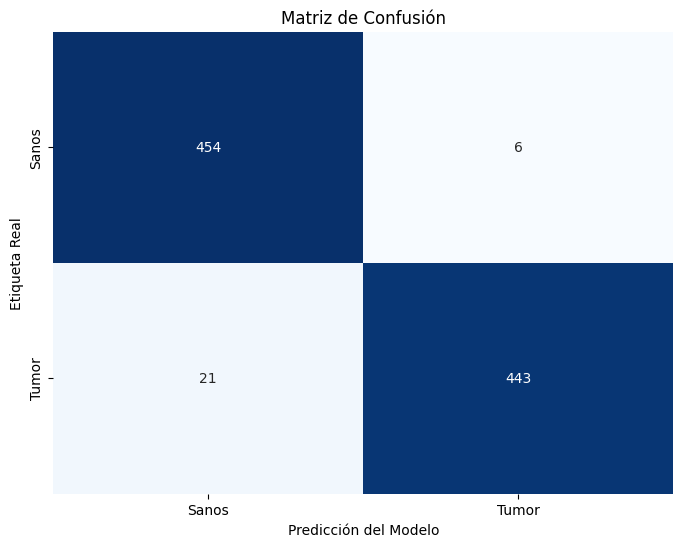

In [ ]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# 3. Modelo de clasificación conjunto MRI

Uso modelos preentrenados para clasificación, los modelos que voy a usar son VGG16 y RESNET50.

## VGG16

### Modelo completo

In [8]:
imagenes_mri = imagenes_mri_sanas_processed + imagenes_mri_tumor_processed
# 0 para sanas, 1 para tumor
labels_mri = [0] * len(imagenes_mri_sanas_processed) + [1] * len(imagenes_mri_tumor_processed)
imagenes_mri = np.array(imagenes_mri)
labels_mri = np.array(labels_mri)
X_train_mri, X_test_mri, y_train_mri, y_test_mri = train_test_split(
    imagenes_mri, labels_mri,
    test_size=0.2, random_state=42, stratify=labels_mri)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_mri)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_mri)}")

Tamaño del conjunto de entrenamiento: 4000
Tamaño del conjunto de prueba: 1000


In [9]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,913 (56.16 MB)

 Trainable params: 14,722,913 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train_mri, y_train_mri, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.5875 - loss: 2.2287 - val_accuracy: 0.5900 - val_loss: 0.6812
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6104 - loss: 0.6756 - val_accuracy: 0.5900 - val_loss: 0.6791
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6121 - loss: 0.6701 - val_accuracy: 0.5900 - val_loss: 0.6788
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6024 - loss: 0.6740 - val_accuracy: 0.5900 - val_loss: 0.6733
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6033 - loss: 0.6717 - val_accuracy: 0.5900 - val_loss: 0.6809
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6074 - loss: 0.6686 - val_accuracy: 0.5900 - val_loss: 0.6707
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6356 - loss: 0.6375 - val_accuracy: 0.7937 - val_loss: 0.5267
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7572 - loss: 0.5375 - val_accuracy: 0

In [12]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9489 - loss: 0.1562
Pérdida en el conjunto de prueba: 0.1410
Precisión en el conjunto de prueba: 0.9530


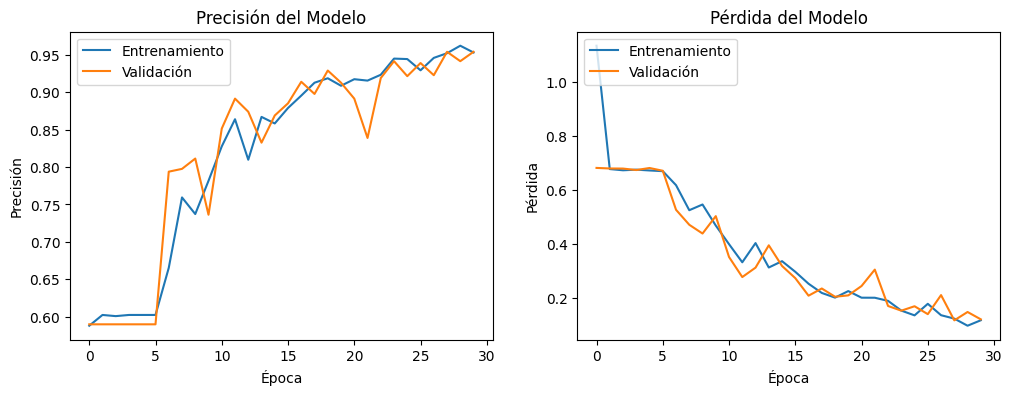

In [13]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


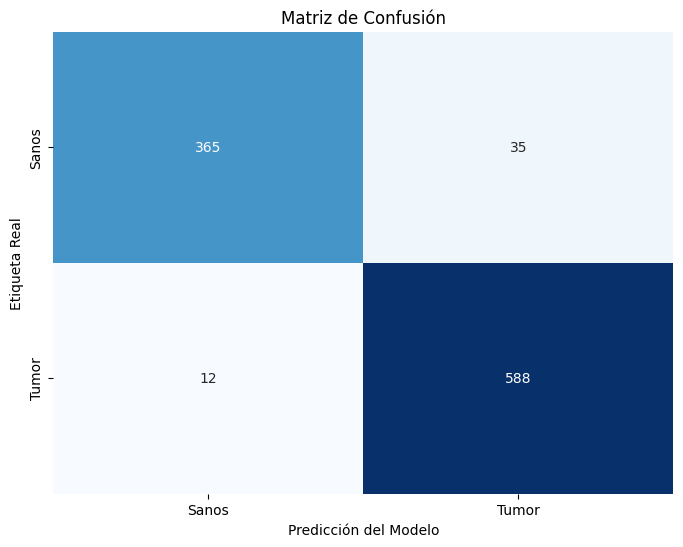

In [14]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo completo

In [48]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,722,913 (56.16 MB)

 Trainable params: 14,722,913 (56.16 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(X_train_mri, y_train_mri, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.7271 - loss: 0.5266 - val_accuracy: 0.9150 - val_loss: 0.2164
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9477 - loss: 0.1532 - val_accuracy: 0.8888 - val_loss: 0.2657
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9241 - loss: 0.1894 - val_accuracy: 0.9787 - val_loss: 0.0697
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9880 - loss: 0.0399 - val_accuracy: 0.9950 - val_loss: 0.0179
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9962 - loss: 0.0170 - val_accuracy: 0.9700 - val_loss: 0.0838
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9900 - val_loss: 0.0300
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9850 - val_loss: 0.0441
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9931 - loss: 0.0168 - val_accuracy: 0

In [51]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9904 - loss: 0.0514
Pérdida en el conjunto de prueba: 0.0373
Precisión en el conjunto de prueba: 0.9950


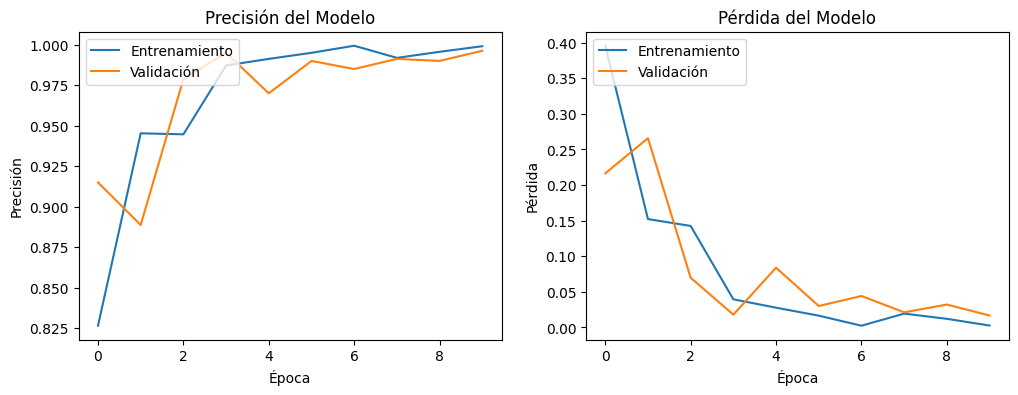

In [52]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


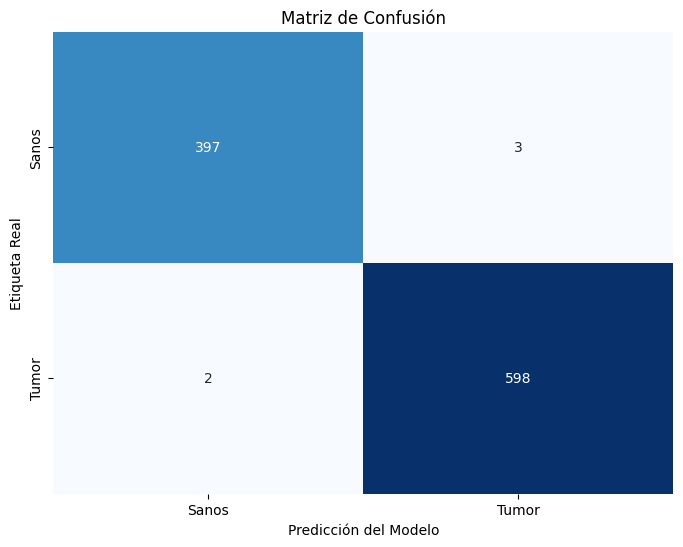

In [53]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con capas congeladas

In [ ]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,784,513 (56.40 MB)

 Trainable params: 69,825 (272.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(X_train_mri, y_train_mri, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.7684 - loss: 0.5258 - val_accuracy: 0.8972 - val_loss: 0.3258
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8978 - loss: 0.2673 - val_accuracy: 0.8985 - val_loss: 0.2567
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9131 - loss: 0.2220 - val_accuracy: 0.9337 - val_loss: 0.2265
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9403 - loss: 0.1826 - val_accuracy: 0.8985 - val_loss: 0.2892
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9296 - loss: 0.1968 - val_accuracy: 0.9107 - val_loss: 0.2245
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9493 - loss: 0.1540 - val_accuracy: 0.9283 - val_loss: 0.2035
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9410 - loss: 0.1677 - val_accuracy: 0.9378 - val_loss: 0.2227
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9516 - loss: 0.1488 - val_accuracy: 0.9445 -

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9706 - loss: 0.1089
Pérdida en el conjunto de prueba: 0.1321
Precisión en el conjunto de prueba: 0.9632


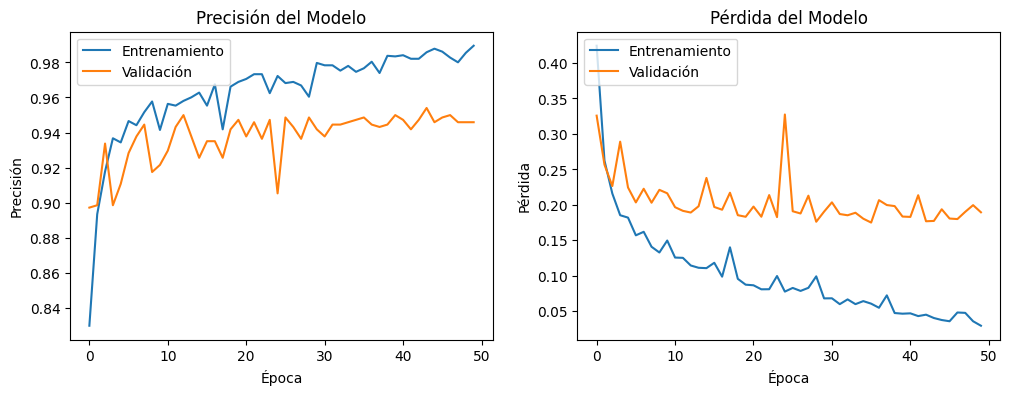

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


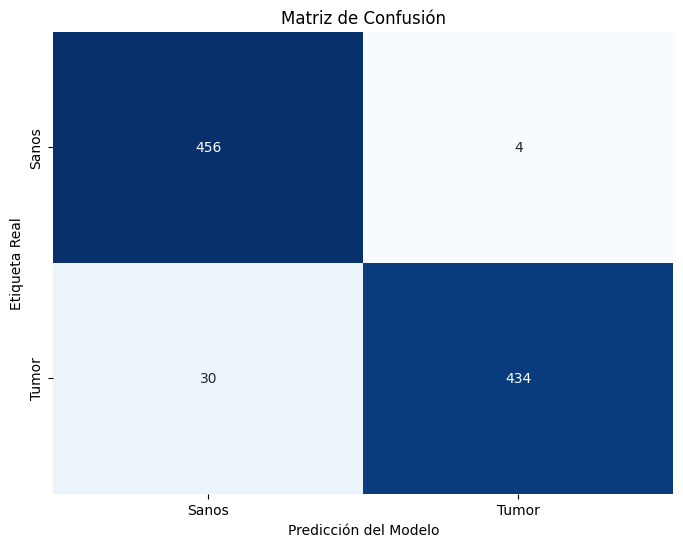

In [ ]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [61]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [62]:
base_model.trainable = True

capas_a_congelar = 17


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [63]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 2,528,193 (9.64 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [64]:
history = model.fit(X_train_mri, y_train_mri, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.6502 - loss: 0.6007 - val_accuracy: 0.8950 - val_loss: 0.2764
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9154 - loss: 0.2209 - val_accuracy: 0.9575 - val_loss: 0.1212
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9556 - loss: 0.1354 - val_accuracy: 0.9750 - val_loss: 0.0860
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9747 - loss: 0.0920 - val_accuracy: 0.9762 - val_loss: 0.0780
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9805 - loss: 0.0573 - val_accuracy: 0.9737 - val_loss: 0.0558
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9744 - loss: 0.0649 - val_accuracy: 0.9775 - val_loss: 0.0594
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9884 - loss: 0.0358 - val_accuracy: 0.9812 - val_loss: 0.0515
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9842 - loss: 0.0497 - val_accuracy: 0.9912 -

In [65]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9902 - loss: 0.0491
Pérdida en el conjunto de prueba: 0.0412
Precisión en el conjunto de prueba: 0.9920


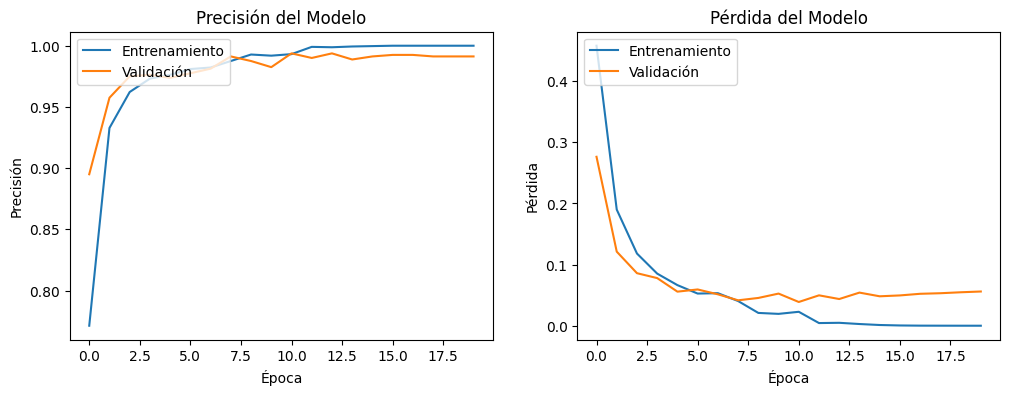

In [66]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


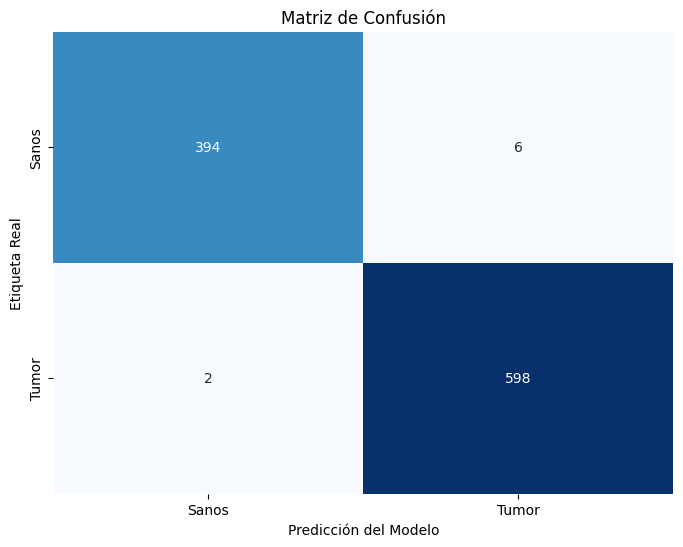

In [67]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [82]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [83]:
base_model.trainable = True

capas_a_congelar = 18


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [84]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 168,385 (657.75 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [85]:
history = model.fit(X_train_mri, y_train_mri, epochs=70, batch_size=64, validation_split=0.2)

Epoch 1/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6697 - loss: 0.6096 - val_accuracy: 0.8950 - val_loss: 0.3107
Epoch 2/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9060 - loss: 0.2634 - val_accuracy: 0.9337 - val_loss: 0.1764
Epoch 3/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9251 - loss: 0.1941 - val_accuracy: 0.9388 - val_loss: 0.1497
Epoch 4/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9395 - loss: 0.1634 - val_accuracy: 0.9450 - val_loss: 0.1366
Epoch 5/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9517 - loss: 0.1258 - val_accuracy: 0.9525 - val_loss: 0.1165
Epoch 6/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9526 - loss: 0.1243 - val_accuracy: 0.9575 - val_loss: 0.1118
Epoch 7/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9607 - loss: 0.1112 - val_accuracy: 0.9500 - val_loss: 0.1206
Epoch 8/70
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9629 - loss: 0.0967 - val_accuracy: 0.9425 -

In [86]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9804 - loss: 0.0764
Pérdida en el conjunto de prueba: 0.0753
Precisión en el conjunto de prueba: 0.9790


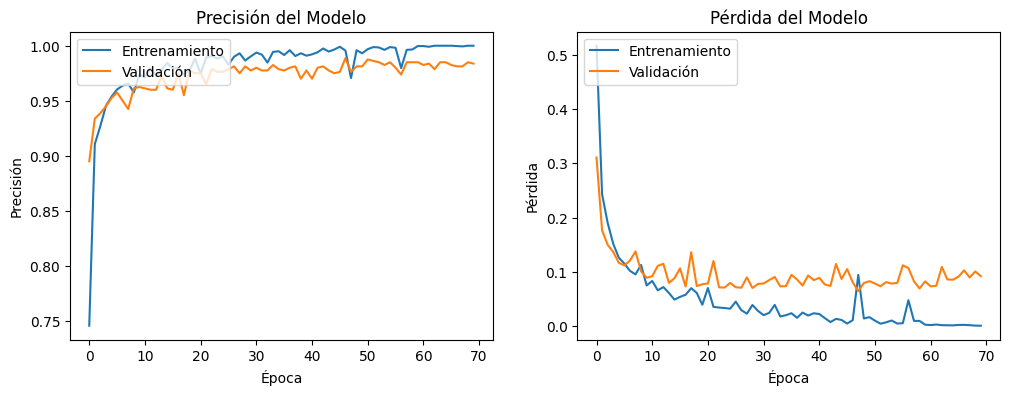

In [87]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


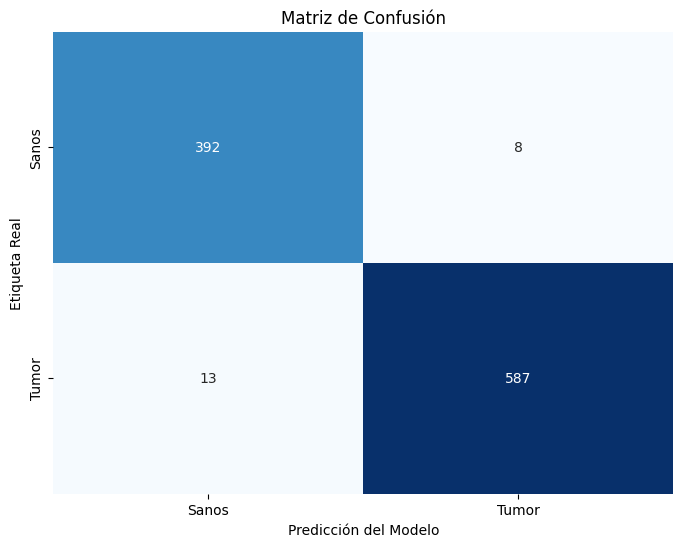

In [88]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [89]:
# Cargo el modelo base VGG16 preentrenado en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [90]:
base_model.trainable = True

capas_a_congelar = 16


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [91]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(32, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,883,073 (56.77 MB)

 Trainable params: 4,888,001 (18.65 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [92]:
history = model.fit(X_train_mri, y_train_mri, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6073 - loss: 0.6552 - val_accuracy: 0.8963 - val_loss: 0.2600
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9025 - loss: 0.2521 - val_accuracy: 0.9563 - val_loss: 0.1275
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9549 - loss: 0.1363 - val_accuracy: 0.9600 - val_loss: 0.0990
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9646 - loss: 0.1001 - val_accuracy: 0.9837 - val_loss: 0.0525
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9803 - loss: 0.0597 - val_accuracy: 0.9925 - val_loss: 0.0270
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9816 - loss: 0.0542 - val_accuracy: 0.9937 - val_loss: 0.0305
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9909 - loss: 0.0304 - val_accuracy: 0.9925 - val_loss: 0.0309
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9962 - loss: 0.0150 - val_accuracy: 0.9925 -

In [93]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9882 - loss: 0.1193
Pérdida en el conjunto de prueba: 0.0877
Precisión en el conjunto de prueba: 0.9940


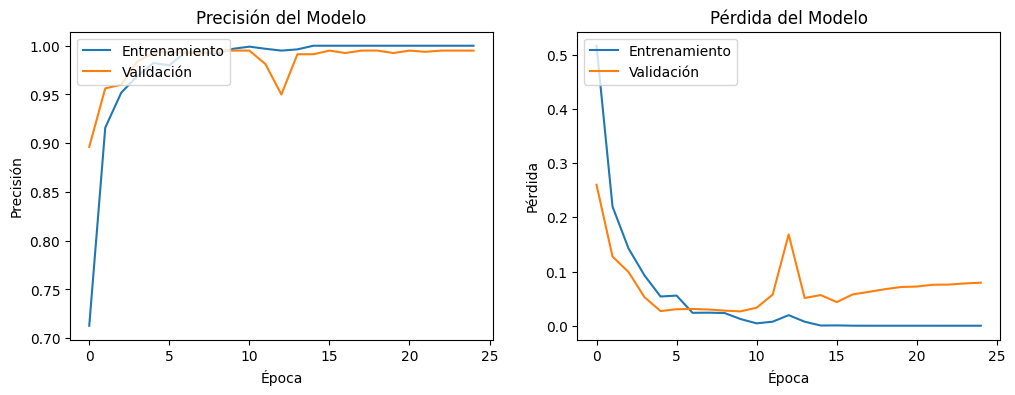

In [94]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


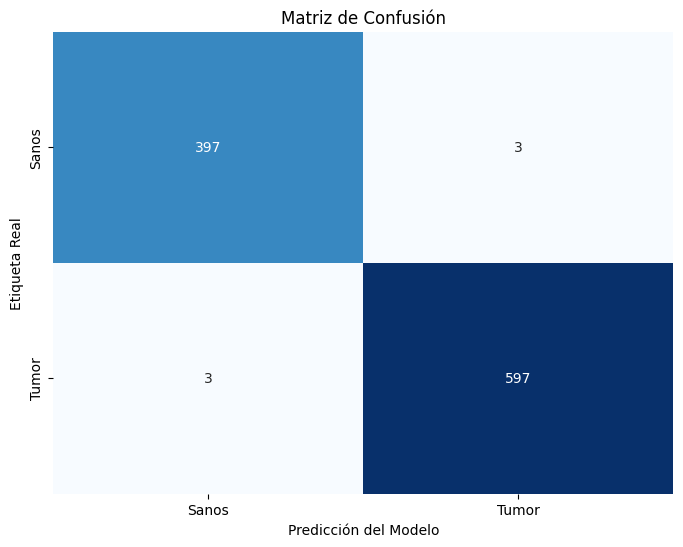

In [95]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## RESNET 50

### Modelo completo

In [96]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [97]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_15[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 23,807,233 (90.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [98]:
history = model.fit(X_train_mri, y_train_mri, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 335ms/step - accuracy: 0.8895 - loss: 0.2737 - val_accuracy: 0.5900 - val_loss: 18.6207
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9773 - loss: 0.0737 - val_accuracy: 0.5900 - val_loss: 1.0543
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9845 - loss: 0.0448 - val_accuracy: 0.5900 - val_loss: 5.9126
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9808 - loss: 0.0647 - val_accuracy: 0.4100 - val_loss: 1.2651
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 0.4100 - val_loss: 6.4855
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9957 - loss: 0.0157 - val_accuracy: 0.4100 - val_loss: 5.2344
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9801 - loss: 0.0525 - val_accuracy: 0.4100 - val_loss: 2.6324
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9951 - loss: 0.0185 - val_accuracy: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.4107 - loss: 7.7022
Pérdida en el conjunto de prueba: 7.7563
Precisión en el conjunto de prueba: 0.4110


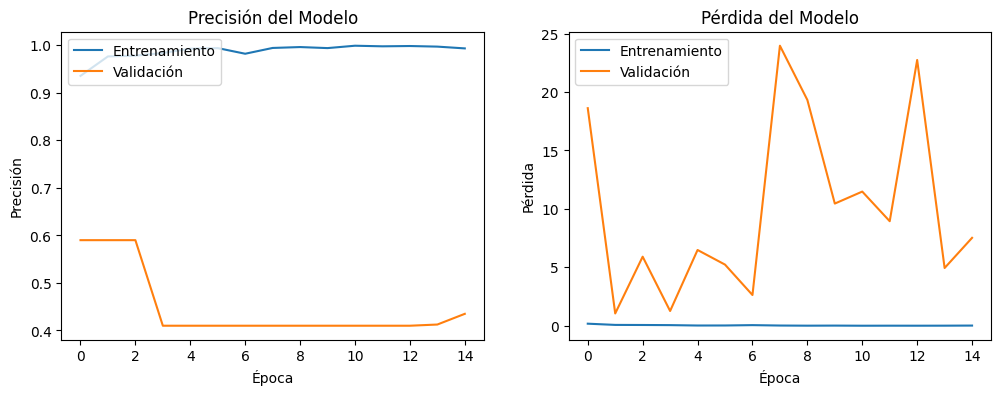

In [99]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step


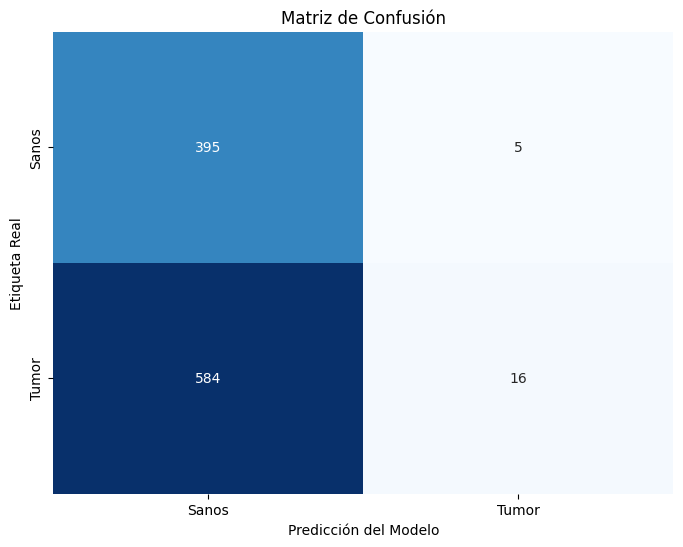

In [100]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con capas congeladas

In [129]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [130]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_22[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [131]:
history = model.fit(X_train_mri, y_train_mri, epochs=90, batch_size=64, validation_split=0.2)

Epoch 1/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.6261 - loss: 0.6544 - val_accuracy: 0.7613 - val_loss: 0.5333
Epoch 2/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7502 - loss: 0.5366 - val_accuracy: 0.7738 - val_loss: 0.4748
Epoch 3/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7730 - loss: 0.4995 - val_accuracy: 0.8025 - val_loss: 0.5083
Epoch 4/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7688 - loss: 0.4990 - val_accuracy: 0.7875 - val_loss: 0.4391
Epoch 5/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7990 - loss: 0.4338 - val_accuracy: 0.7825 - val_loss: 0.4432
Epoch 6/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8110 - loss: 0.4070 - val_accuracy: 0.8138 - val_loss: 0.3957
Epoch 7/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8138 - loss: 0.4070 - val_accuracy: 0.8213 - val_loss: 0.3953
Epoch 8/90
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8241 - loss: 0.3931 - val_accuracy: 0.8025 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9061 - loss: 0.2434
Pérdida en el conjunto de prueba: 0.2380
Precisión en el conjunto de prueba: 0.9100


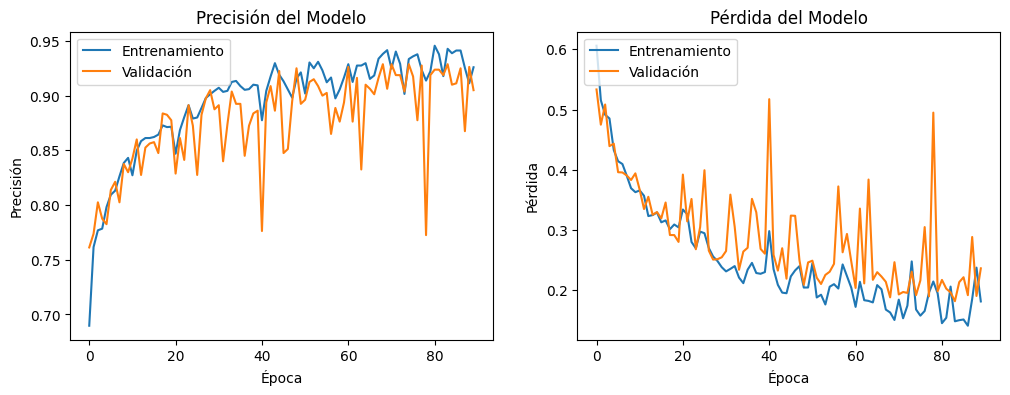

In [132]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step


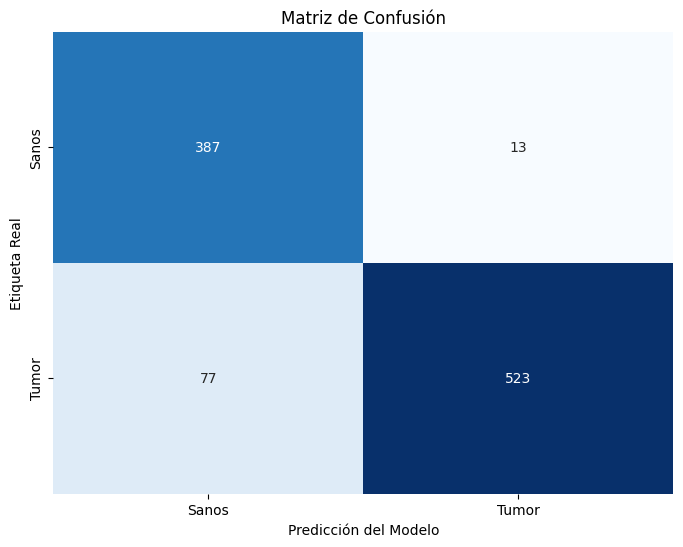

In [133]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Transfer Learning en dos pasos

In [134]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [135]:
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_23[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [136]:
history = model.fit(X_train_mri, y_train_mri, epochs=80, batch_size=64, validation_split=0.2)

Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.6649 - loss: 0.6488 - val_accuracy: 0.7487 - val_loss: 0.5535
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7529 - loss: 0.5363 - val_accuracy: 0.7725 - val_loss: 0.4787
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7785 - loss: 0.4688 - val_accuracy: 0.7750 - val_loss: 0.4501
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8075 - loss: 0.4363 - val_accuracy: 0.8100 - val_loss: 0.4434
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8067 - loss: 0.4159 - val_accuracy: 0.8188 - val_loss: 0.4000
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8099 - loss: 0.4154 - val_accuracy: 0.8275 - val_loss: 0.3818
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8252 - loss: 0.3878 - val_accuracy: 0.8150 - val_loss: 0.3750
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8123 - loss: 0.4069 - val_accuracy: 0.8313 -

In [137]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [138]:
history = model.fit(X_train_mri, y_train_mri, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 251ms/step - accuracy: 0.6733 - loss: 35.1095 - val_accuracy: 0.4050 - val_loss: 17.1768
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9762 - loss: 0.9324 - val_accuracy: 0.4100 - val_loss: 40.4554
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9886 - loss: 0.4696 - val_accuracy: 0.4100 - val_loss: 47.4949
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9951 - loss: 0.0809 - val_accuracy: 0.4112 - val_loss: 49.8054
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9985 - loss: 0.0226 - val_accuracy: 0.4137 - val_loss: 45.8613
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9984 - loss: 0.0292 - val_accuracy: 0.4187 - val_loss: 47.2296
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.4150 - val_loss: 49.5780
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9989 - loss: 0.0424 - val_acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9899 - loss: 0.3172
Pérdida en el conjunto de prueba: 0.3147
Precisión en el conjunto de prueba: 0.9920


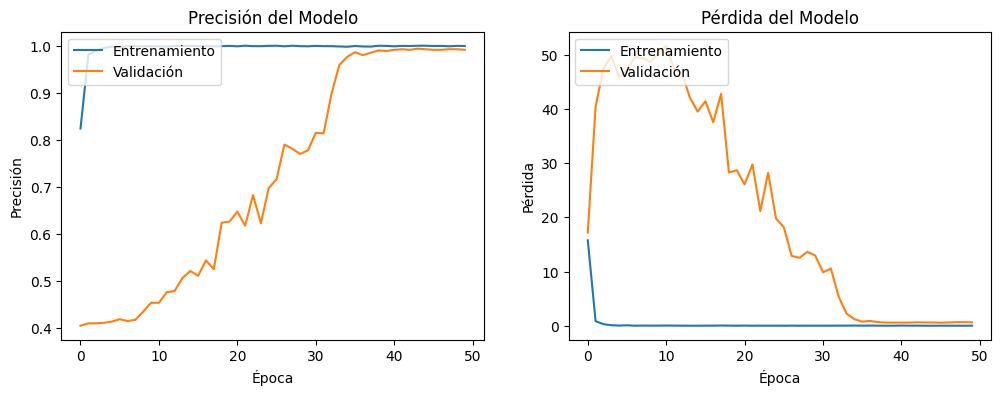

In [139]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step


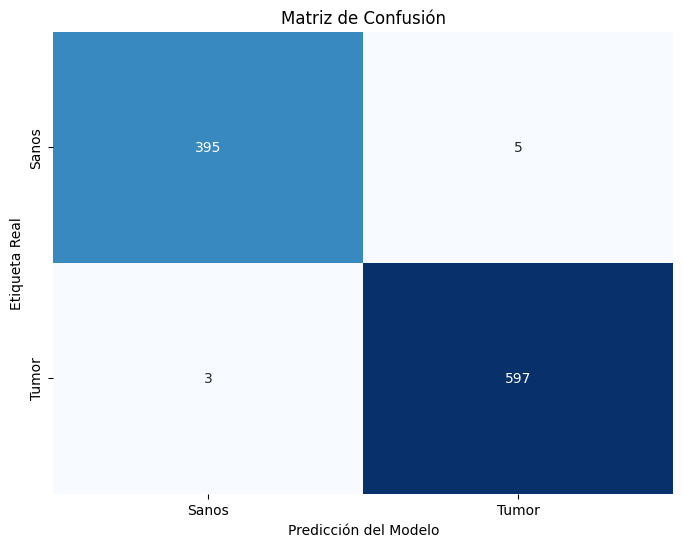

In [140]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [141]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [142]:
base_model.trainable = True

capas_a_congelar = 143


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [143]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_24[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 15,248,641 (58.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [144]:
history = model.fit(X_train_mri, y_train_mri, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 394ms/step - accuracy: 0.7757 - loss: 0.4360 - val_accuracy: 0.7775 - val_loss: 0.6562
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9352 - loss: 0.1674 - val_accuracy: 0.7875 - val_loss: 0.6440
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9647 - loss: 0.1082 - val_accuracy: 0.7713 - val_loss: 0.5855
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9708 - loss: 0.0833 - val_accuracy: 0.7937 - val_loss: 0.5341
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9757 - loss: 0.0696 - val_accuracy: 0.8238 - val_loss: 0.5357
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9798 - loss: 0.0562 - val_accuracy: 0.8675 - val_loss: 0.3667
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9878 - loss: 0.0388 - val_accuracy: 0.8963 - val_loss: 0.2474
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9881 - loss: 0.0353 - val_accuracy: 0.6587 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9638 - loss: 0.1489
Pérdida en el conjunto de prueba: 0.1313
Precisión en el conjunto de prueba: 0.9620


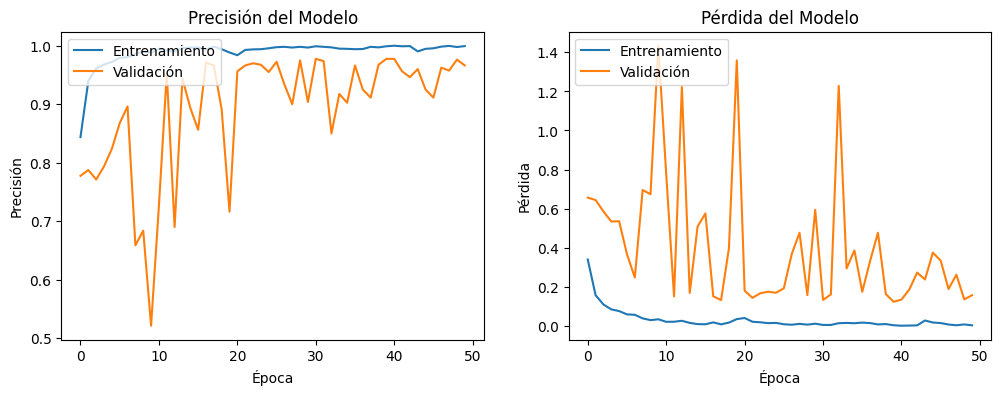

In [145]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step


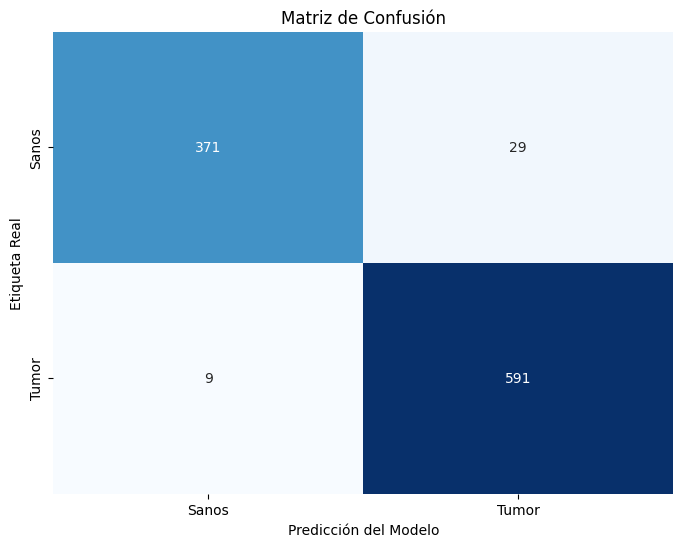

In [146]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

### Modelo con x capas congeladas

In [147]:
# Cargo el modelo base ResNet preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [148]:
base_model.trainable = True

capas_a_congelar = 80


for layer in base_model.layers[:capas_a_congelar]:
    layer.trainable = False

In [149]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_25[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,860,353 (91.02 MB)

 Trainable params: 22,357,249 (85.29 MB)

 Non-trainable params: 1,503,104 (5.73 MB)

In [150]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

history = model.fit(X_train_mri, y_train_mri, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 431ms/step - accuracy: 0.7879 - loss: 0.4101 - val_accuracy: 0.4100 - val_loss: 0.7706
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9565 - loss: 0.1360 - val_accuracy: 0.3900 - val_loss: 0.8804
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9793 - loss: 0.0637 - val_accuracy: 0.3137 - val_loss: 1.0551
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9895 - loss: 0.0403 - val_accuracy: 0.5738 - val_loss: 1.0784
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9869 - loss: 0.0376 - val_accuracy: 0.6862 - val_loss: 0.9571
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9927 - loss: 0.0251 - val_accuracy: 0.6850 - val_loss: 1.4203
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9925 - loss: 0.0232 - val_accuracy: 0.7075 - val_loss: 1.2072
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9759 - loss: 0.1318
Pérdida en el conjunto de prueba: 0.0744
Precisión en el conjunto de prueba: 0.9830


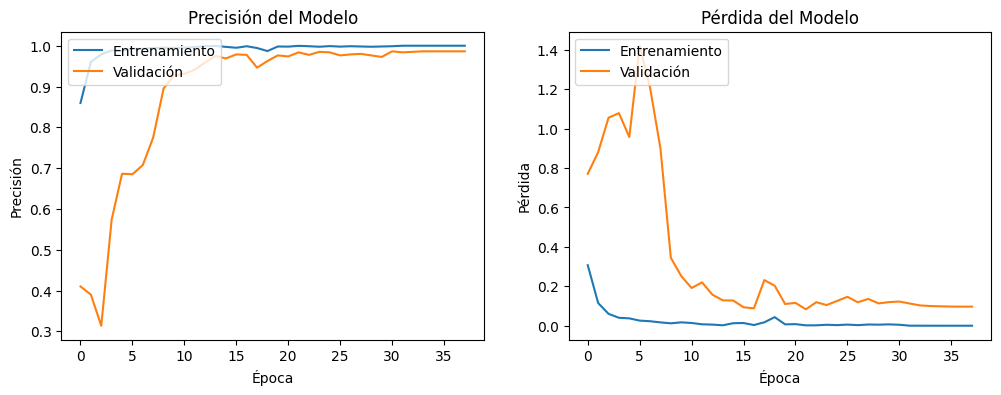

In [151]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step


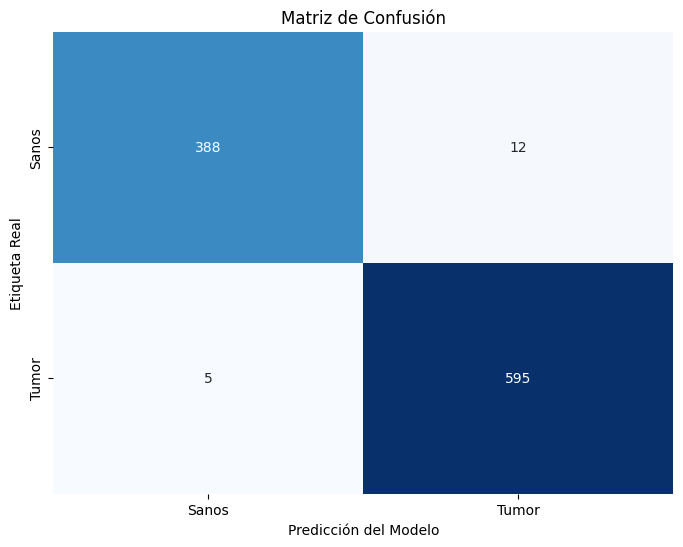

In [152]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()